<a href="https://colab.research.google.com/github/zktuong/dandelion/blob/master/container/dandelion_singularity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to `dandelion`
<img src='https://github.com/zktuong/dandelion/blob/master/docs/notebooks/img/dandelion_logo_illustration.png?raw=true' />

## **Set up python environment**

In [1]:
# install dependencies with pip
!python -m pip install -q scanpy[leiden]==1.9.1 sc-dandelion==0.2.4 -U 
# ignore the pip dependency error

     |████████████████████████████████| 10.3 MB 25.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 2.0 MB 27.4 MB/s 
     |████████████████████████████████| 463 kB 62.1 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 180 kB 54.1 MB/s 
     |████████████████████████████████| 150 kB 56.2 MB/s 
     |████████████████████████████████| 1.3 MB 53.9 MB/s 
     |████████████████████████████████| 96 kB 4.8 MB/s 
     |████████████████████████████████| 88 kB 6.4 MB/s 
     |████████████████████████████████| 2.3 MB 63.4 MB/s 
     |████████████████████████████████| 596 kB 21.3 MB/s 
     |████████████████████████████████| 109 kB 44.9 MB/s 
     |██████████████████████████

In [2]:
import dandelion as ddl
ddl.logging.print_header()

dandelion==0.2.4 pandas==1.3.5 numpy==1.21.6 matplotlib==3.2.2 networkx==2.6.3 scipy==1.4.1


## **Setup Singularity**

On top of installing `dandelion`, we will set up `singularity` for running the preprocessing as it requires several non-python softwares and database dependencies that are easily taken care of by the container. Please be patient as the following steps will take ~10-15 mins.

In [3]:
%%time
# set up singularity
!echo 'debconf debconf/frontend select Noninteractive' | sudo debconf-set-selections
!sudo apt-get -qq update && sudo apt-get install build-essential libssl-dev uuid-dev libgpgme11-dev squashfs-tools libseccomp-dev pkg-config -qq > /dev/null
!export VERSION=1.13 OS=linux ARCH=amd64 && wget -q https://dl.google.com/go/go$VERSION.$OS-$ARCH.tar.gz && sudo tar -C /usr/local -xzf go$VERSION.$OS-$ARCH.tar.gz && rm go$VERSION.$OS-$ARCH.tar.gz
!if [ ! -d "singularity" ]; then git clone https://github.com/sylabs/singularity.git -q; fi
!export GOPATH=${HOME}/go && export PATH=/usr/local/go/bin:${PATH}:${GOPATH}/bin && cd singularity && git checkout -q v3.6.1 && ./mconfig >/dev/null 2>/dev/null && make -C ./builddir >/dev/null 2>/dev/null && sudo make -C ./builddir install >/dev/null 2>/dev/null
# Download the `dandelion` singularity image
!if [ ! -e "sc-dandelion_latest.sif" ]; then singularity -s pull library://kt16/default/sc-dandelion:latest; fi

CPU times: user 2.57 s, sys: 374 ms, total: 2.94 s
Wall time: 5min 31s


Normally, to check whether everything is set up properly, the following command will print out the help message from the preprocessing script in the container:

```bash
singularity run -B $PWD sc-dandelion_latest.sif dandelion-preprocess --help
```

However, in order to mount the container in this google colab notebook, we have to add an additional step to convert it into sandbox mode and install `ipykernel`. Also, ignore any `LD_PRELOAD` error message that appears throughout later.

In [4]:
# Convert to sandbox mode to make it work for google colab notebook
!sudo singularity build --sandbox sc-dandelion_latest sc-dandelion_latest.sif && singularity -s exec -u -B $PWD sc-dandelion_latest pip install ipykernel -q

INFO:    Starting build...
INFO:    Creating sandbox directory...
INFO:    Build complete: sc-dandelion_latest
ERROR: ld.so: object '/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4' from LD_PRELOAD cannot be preloaded (cannot open shared object file): ignored.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Now to check if everything is set up properly:

In [5]:
# Note: I'm calling the sandbox directory rather than the .sif image file
!singularity run -u -B $PWD sc-dandelion_latest dandelion-preprocess --help

ERROR: ld.so: object '/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4' from LD_PRELOAD cannot be preloaded (cannot open shared object file): ignored.
ERROR: ld.so: object '/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4' from LD_PRELOAD cannot be preloaded (cannot open shared object file): ignored.
ERROR: ld.so: object '/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4' from LD_PRELOAD cannot be preloaded (cannot open shared object file): ignored.
ERROR: ld.so: object '/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4' from LD_PRELOAD cannot be preloaded (cannot open shared object file): ignored.
Software versions:

dandelion==0.2.4 pandas==1.4.3 numpy==1.22.4 matplotlib==3.5.2 networkx==2.8.4 scipy==1.8.1
usage: dandelion_preprocess.py
       [-h]
       [--meta META]
       [--chain CHAIN]
       [--file_prefix FILE_PREFIX]
       [--sep SEP]
       [--flavour FLAVOUR]
       [--skip_format_header]
       [--filter_to_high_confidence]
       [--skip_reassign_dj]
       [--keep_trailing_hyphen_number]
      

## **Download example datasets from 10X**

We will download example datasets freely available from 10X Genomics. To keep this tutorial short, we will trim to just 5000 contigs in both files but definitely do try it again later on the full datasets!

In [6]:
!if [ ! -d "/content/example/sc5p_v2_hs_B_prevax" ]; then mkdir -p /content/example/sc5p_v2_hs_B_prevax; fi
!cd /content/example/sc5p_v2_hs_B_prevax && wget -q -O filtered_feature_bc_matrix.h5 https://cf.10xgenomics.com/samples/cell-vdj/5.0.0/sc5p_v2_hs_B_prevax_10k_5gex_B/sc5p_v2_hs_B_prevax_10k_5gex_B_count_filtered_feature_bc_matrix.h5
!cd /content/example/sc5p_v2_hs_B_prevax && wget -q -O filtered_contig.fasta https://cf.10xgenomics.com/samples/cell-vdj/5.0.0/sc5p_v2_hs_B_prevax_10k_5gex_B/sc5p_v2_hs_B_prevax_10k_5gex_B_vdj_b_filtered_contig.fasta
!cd /content/example/sc5p_v2_hs_B_prevax && wget -q -O filtered_contig_annotations.csv https://cf.10xgenomics.com/samples/cell-vdj/5.0.0/sc5p_v2_hs_B_prevax_10k_5gex_B/sc5p_v2_hs_B_prevax_10k_5gex_B_vdj_b_filtered_contig_annotations.csv

!if [ ! -d "/content/example/sc5p_v2_hs_B_postvax" ]; then mkdir -p /content/example/sc5p_v2_hs_B_postvax; fi
!cd /content/example/sc5p_v2_hs_B_postvax && wget -q -O filtered_feature_bc_matrix.h5 https://cf.10xgenomics.com/samples/cell-vdj/5.0.0/sc5p_v2_hs_B_postvax_10k_5gex_B/sc5p_v2_hs_B_postvax_10k_5gex_B_count_filtered_feature_bc_matrix.h5
!cd /content/example/sc5p_v2_hs_B_postvax && wget -q -O filtered_contig.fasta https://cf.10xgenomics.com/samples/cell-vdj/5.0.0/sc5p_v2_hs_B_postvax_10k_5gex_B/sc5p_v2_hs_B_postvax_10k_5gex_B_vdj_b_filtered_contig.fasta
!cd /content/example/sc5p_v2_hs_B_postvax && wget -q -O filtered_contig_annotations.csv https://cf.10xgenomics.com/samples/cell-vdj/5.0.0/sc5p_v2_hs_B_postvax_10k_5gex_B/sc5p_v2_hs_B_postvax_10k_5gex_B_vdj_b_filtered_contig_annotations.csv

# trim to just 5000 contigs to make this tutorial shorter
!cd /content/example/sc5p_v2_hs_B_prevax && head -10000 filtered_contig.fasta > filtered_5k_contig.fasta && sed -i '1,+9999d' filtered_contig.fasta && head -5001 filtered_contig_annotations.csv > filtered_5k_contig_annotations.csv && sed -i '1,+5000d' filtered_contig_annotations.csv
!cd /content/example/sc5p_v2_hs_B_postvax && head -10000 filtered_contig.fasta > filtered_5k_contig.fasta && sed -i '1,+9999d' filtered_contig.fasta && head -5001 filtered_contig_annotations.csv > filtered_5k_contig_annotations.csv && sed -i '1,+5000d' filtered_contig_annotations.csv

## **Preprocessing 10x outputs with singularity image**

As there are two folders to process, we will create a `.csv` file for the `--meta` option that tells the script which folders (`sample_id`) to run the preprocessing, whether to append any `prefix`/`suffix`, and whether the folders belong to a particular `individual` (for [TIgGER](https://tigger.readthedocs.io/)).

In [7]:
import pandas as pd
meta = pd.DataFrame([['sc5p_v2_hs_B_prevax', 'prevax', 'sc5p_v2'], 
                     ['sc5p_v2_hs_B_postvax', 'postvax', 'sc5p_v2']], 
                    columns = ['sample_id', 'prefix', 'individual'])
meta.to_csv('/content/example/meta.csv', index = False)
meta

,sample_id,prefix,individual
0,sc5p_v2_hs_B_prevax,prevax,sc5p_v2
1,sc5p_v2_hs_B_postvax,postvax,sc5p_v2


And now to actually run the preprocessing. The number of input contigs and `cpus` available determine how fast this step completes. In this google colab notebook, it typically takes ~15 min to process the two folders.

In [8]:
%%time
!cd /content/example && singularity run -u -B $PWD ../sc-dandelion_latest dandelion-preprocess \
  --meta meta.csv \
  --chain IG \
  --file_prefix filtered_5k \
  --keep_trailing_hyphen_number

ERROR: ld.so: object '/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4' from LD_PRELOAD cannot be preloaded (cannot open shared object file): ignored.
ERROR: ld.so: object '/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4' from LD_PRELOAD cannot be preloaded (cannot open shared object file): ignored.
Software versions:

dandelion==0.2.4 pandas==1.4.3 numpy==1.22.4 matplotlib==3.5.2 networkx==2.8.4 scipy==1.8.1

Beginning preprocessing

command line parameters:
: 
--------------------------------------------------------------
    --meta = meta.csv
    --chain = ig
    --file_prefix = filtered_5k
    --sep = _
    --flavour = strict
    --skip_format_header = False
    --filter_to_high_confidence = False
    --keep_trailing_hyphen_number = True
    --skip_reassign_dj = False
    --clean_output = False
--------------------------------------------------------------

Formating fasta(s) : 100% 2/2 [00:00<00:00,  4.88it/s]
Assigning genes :   0% 0/2 [00:00<?, ?it/s]Processing sc5p_v2_hs_B_prevax/dandelio

And now we have a processed output (`filtered_5k_contig_dandelion.tsv`) in each folder that can be used for downstream exploration.

## **Post-processing**

The data is now ready for post-processing QCs and analysis. To start, let's first prepare the single-cell gene expression data.

### Import the transcriptome data

In [9]:
import scanpy as sc

adatas = []
for sample in ['prevax', 'postvax']:
  adata = sc.read_10x_h5('/content/example/sc5p_v2_hs_B_'+sample+'/filtered_feature_bc_matrix.h5')
  adata.var_names_make_unique()
  adata.obs_names = [sample + '_' + o for o in adata.obs_names]
  adata.obs['sample_id'] = sample
  adatas.append(adata)
adata = sc.concat(adatas)
adata

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 18115 × 36601
    obs: 'sample_id'

### Import the BCR data

In [10]:
import pandas as pd
# first we read in the 2 processed files
bcr_files = []
for sample in ['prevax', 'postvax']:
    file_location = '/content/example/sc5p_v2_hs_B_'+sample+'/dandelion/filtered_5k_contig_dandelion.tsv'
    bcr_files.append(pd.read_csv(file_location, sep = '\t'))
bcr = bcr_files[0].append(bcr_files[1])
bcr.reset_index(inplace = True, drop = True)
bcr

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,...,fwr4_aa,cdr1_aa,cdr2_aa,cdr3_aa,sequence_alignment_aa,v_sequence_alignment_aa,d_sequence_alignment_aa,j_sequence_alignment_aa,mu_count,mu_freq
0,prevax_AAACCTGAGAGACGAA-1_contig_1,GCCTGGGTCAGAGCTCTGGGGAGGAACTGCTCACTTAGGACCCAGA...,F,T,IGKV3-15*01,NaN,IGKJ4*01,GAAATAGTGATGACGCAGTCTCCAGCCACCCTGTCTGTGTCTCCGG...,GAAATAGTGATGACGCAGTCTCCAGCCACCCTGTCTGTGTCTCCAG...,TGTCAGCAGTATAATAACTGGCCTCTCACTTTC,...,FGGGTKVEIK,QSVSSN,GAS,QQYNNWPLT,EIVMTQSPATLSVSPGERATLSCRASQSVSSNLAWYQHKPGQAPRL...,EIVMTQSPATLSVSPGERATLSCRASQSVSSNLAWYQHKPGQAPRL...,NaN,TFGGGTKVEIK,2,0.006231
1,prevax_AAACCTGAGAGACGAA-1_contig_2,AGCTCTGAGAGAGGAGCCCAGCCCTGGGATTTTCAGGTGTTTTCAT...,F,T,"IGHV3-23*01,IGHV3-23D*01",IGHD5-24*01,IGHJ4*02,GAGGTGCAGCTGTTGGAGTCTGGGGGA...GGCTTGGTACAGCCTG...,GAGGTGCAGCTGTTGGAGTCTGGGGGA...GGCTTGGTACAGCCTG...,TGTGCCGCTACCCTAGGGACCCGTAGAGATGGTTACAATTTTGCAT...,...,WGQETLVTVSS,GVTFNSYA,ISGSGANT,AATLGTRRDGYNFAY,EVQLLESGGGLVQPGGSLRLSCAASGVTFNSYAMSWVRQAPGKGLE...,EVQLLESGGGLVQPGGSLRLSCAASGVTFNSYAMSWVRQAPGKGLE...,RDGYN,YWGQETLVTVSS,7,0.021472
2,prevax_AAACCTGAGCGCCTTG-1_contig_1,GATCAGGACTCCTCAGTTCACCTTCTCACAATGAGGCTCCCTGCTC...,F,T,IGKV2-30*01,NaN,IGKJ3*01,GATGTTGTGATGACTCAGTCTCCACTCTCCCTGCCCGTCACCCTTG...,GATGTTGTGATGACTCAGTCTCCACTCTCCCTGCCCGTCACCCTTG...,TGCATGCAAGGTACACACTGGCGTTTCACTTTC,...,FGPGTKVDIK,QSLVYSDGNTY,KVS,MQGTHWRFT,DVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPG...,DVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPG...,NaN,FTFGPGTKVDIK,2,0.005988
3,prevax_AAACCTGAGCGCCTTG-1_contig_2,CGAGCCCAGCACTGGAAGTCGCCGGTGTTTCCATTCGGTGATCAGC...,F,T,"IGHV3-30*04,IGHV3-30-3*03",NaN,IGHJ3*02,CAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCGTGGTCCAGCCTG...,CAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCGTGGTCCAGCCTG...,TGTGCGAGTTTCGACTACCATAGTGCTTTTGATATCTGG,...,WGQGTMVTVSS,GFTFSTYD,ISYDGSNK,ASFDYHSAFDI,QVQLVESGGGVVQPGRSLRLSCAASGFTFSTYDMHWVRQAPGEGLE...,QVQLVESGGGVVQPGRSLRLSCAASGFTFSTYDMHWVRQAPGEGLE...,NaN,AFDIWGQGTMVTVSS,8,0.023599
4,prevax_AAACCTGAGTGAACAT-1_contig_1,TATATAGGGGGAGTCAGTCTCAGTCAGGACACAGCATGGACATGAG...,F,T,"IGKV1-39*01,IGKV1D-39*01",NaN,IGKJ2*03,GACATCCAGATGACCCAGTCTCCATCCTCCCTGTCTGCATCTGTGG...,GACATCCAGATGACCCAGTCTCCATCCTCCCTGTCTGCATCTGTAG...,TGTCAACAGAGTTACAGTACCCCTCCGTATAGTTTT,...,FGQGTKLEIK,QNIGSY,AAS,QQSYSTPPYS,DIQMTQSPSSLSASVGDRVTITCRAGQNIGSYLNWYQQKAGKAPKL...,DIQMTQSPSSLSASVGDRVTITCRAGQNIGSYLNWYQQKAGKAPKL...,NaN,YSFGQGTKLEIK,24,0.074074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9891,postvax_CAGTAACTCTTCAACT-1_contig_1,GAGCTCTGGGAGAGGAGCCCAGCACTAGAAGTCGGCGGTGTTTCCA...,F,T,"IGHV3-33*01,IGHV3-33*05,IGHV3-33*06",NaN,IGHJ4*02,CAGGTGAAGCTGGTGGAGTCTGGGGGA...GGCGTGGTCCAGGCGG...,CAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCGTGGTCCAGCCTG...,TGTGCGTCAGGGGTGGGGGCTACTCGCTACTTTGACTACTGG,...,WGQGTLVTVSS,GFTFRNYG,IFYDGSDQ,ASGVGATRYFDY,QVKLVESGGGVVQAGRSLRLSCAASGFTFRNYGMHWVRQAPGKGLE...,QVKLVESGGGVVQAGRSLRLSCAASGFTFRNYGMHWVRQAPGKGLE...,NaN,YFDYWGQGTLVTVSS,17,0.050445
9892,postvax_CAGTCCTAGGACGAAA-1_contig_1,GGAGCAGAAAGGGGAGGCAGATTGTCTCTGCAGCTGCAAGCCCAGC...,F,T,IGKV3-20*01,NaN,IGKJ1*01,GAAATTGTGTTGACGCAGTCTCCAGGCACCCTGTCTTTGTCTCCAG...,GAAATTGTGTTGACGCAGTCTCCAGGCACCCTGTCTTTGTCTCCAG...,TGTCAGCAGTATGGTAGCTCAACAGGGACGTTC,...,FGQGTKVEIK,QSVSSSY,GAS,QQYGSSTGT,EIVLTQSPGTLSLSPGERATLSCRASQSVSSSYLAWYQQKPGQAPR...,EIVLTQSPGTLSLSPGERATLSCRASQSVSSSYLAWYQQKPGQAPR...,NaN,TFGQGTKVEIK,0,0.000000
9893,postvax_CAGTCCTAGGACGAAA-1_contig_2,ATCACATAACAACCACATTCCTCCTCTAAAGAAGCCCCTGGGAGCA...,F,T,"IGHV1-69*01,IGHV1-69D*01",IGHD2-15*01,IGHJ4*02,CAGGTGCAGCTGGTGCAGTCTGGGGCT...GAGGTGAAGAAGCCTG...,CAGGTGCAGCTGGTGCAGTCTGGGGCT...GAGGTGAAGAAGCCTG...,TGTGCGAGAGAGAGGGTCCCCCTTGATATTGTAGTGGTGGTAGCTG...,...,WGQGTLVTVSS,GGTFSSYA,IIPIFGTA,ARERVPLDIVVVVAATYYFDY,QVQLVQSGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLE...,QVQLVQSGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLE...,DIVVVVAAT,YFDYWGQGTLVTVSS,0,0.000000
9894,postvax_CAGTCCTAGGCATTGG-1_contig_2,GTGGGCTCAGAAGCAGAGTTCTGGGGTGTCTCCACCATGGCCTGGA...,F,T,IGLV

### **Run QC on both the V(D)J data and transcriptome data**

We use the function `pp.check_contigs` to mark ambiguous contigs in the V(D)J data and `Dandelion` will subsequently know which contigs to transfer to the transcriptome adata's `.obs`.

In [11]:
vdj, adata = ddl.pp.check_contigs(bcr, adata)
vdj

Preparing data: 9896it [00:05, 1807.03it/s]
Scanning for poor quality/ambiguous contigs: 100%|██████████| 4713/4713 [00:45<00:00, 102.63it/s]


Dandelion class object with n_obs = 4713 and n_contigs = 9896
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'duplicate_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_bla

Also run through a generic `scanpy` preprocessing workflow on the `AnnData` object.

In [12]:
# filter genes
sc.pp.filter_genes(adata, min_cells=3)
# Normalize the counts
sc.pp.normalize_total(adata, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata)
# Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# remove VDJ genes from highly variable. This is a personal choice.
import re
for i in adata.var.index:
    if re.search('^TR[AB][VDJ]|^IG[HKL][VDJC]', i):
        adata.var.at[i, 'highly_variable'] = False
# stash in raw
adata.raw = adata
# filter to only highly variable
adata = adata[:, adata.var.highly_variable].copy()
# scale
sc.pp.scale(adata, max_value=10)
# pca
sc.tl.pca(adata, svd_solver='arpack')
# Computing the neighborhood graph
sc.pp.neighbors(adata)
# umap
sc.tl.umap(adata)
# Cluster
sc.tl.leiden(adata)
adata

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


AnnData object with n_obs × n_vars = 18115 × 868
    obs: 'sample_id', 'has_contig', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_genotyped_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_genotyped_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_genotyped_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_genotyped_B_VJ', 'j_call_B_VJ', 'c_call_B_VDJ', 'c_call_B_VJ', 'productive_B_VDJ', 'productive_B_VJ', 'duplicate_count_B_VDJ', 'duplicate_count_B_VJ', 'isotype', 'isotype_status', 'locus_status', 'chain_status', 'rearrangement_status_VDJ', 'rearrangement_status_VJ', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [17]:
# save because there maybe issues with plotting-
adata.write_h5ad('adata.h5ad', compression = 'gzip')

In [18]:
vdj.write_h5ddl('vdj.h5ddl')

In [19]:
# if you run into any issues with plotting below, run this and restart the runtime
!python -m pip install -q matplotlib -U

     |████████████████████████████████| 11.2 MB 27.5 MB/s 
     |████████████████████████████████| 944 kB 39.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
import scanpy as sc
import dandelion as ddl

adata = sc.read_h5ad('adata.h5ad')
vdj = ddl.read_h5ddl('vdj.h5ddl')

### Visualizing the clusters and whether or not there’s a corresponding V(D)J receptor

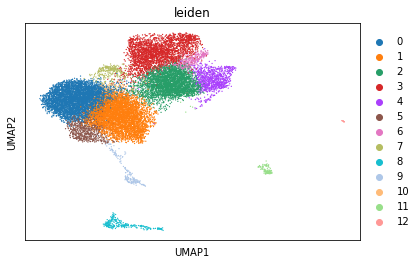

In [2]:
sc.pl.umap(adata, color=['leiden'])

The naming for the chain_statuses should be self-explanatory and are very similar to how `scirpy` names their `chain_pairing`. A key difference is the `-exception` flags. They indicate special circumstances that `Dandelion` prefers to be more lenient. For example, IgM/IgD cells will be flagged as `Extra pair-exception` due to having an extra IGH contig.

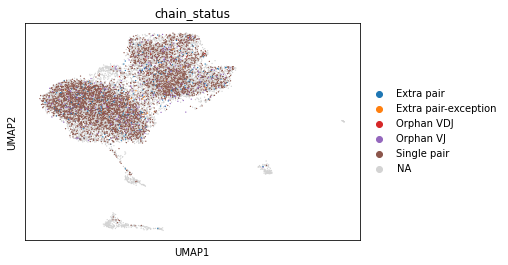

In [3]:
sc.pl.umap(adata, color=['chain_status'], groups = ['Single pair', 'Extra pair', 'Extra pair-exception', 'Orphan VDJ', 'Orphan VJ'], ncols = 1)

### Finding clones

In [4]:
ddl.tl.find_clones(vdj)

Finding clones based on B cell VDJ chains : 100%|██████████| 242/242 [00:00<00:00, 650.29it/s]
Refining clone assignment based on VJ chain pairing : 100%|██████████| 4379/4379 [00:00<00:00, 191622.84it/s]


### Generate BCR network

In [5]:
ddl.tl.generate_network(vdj)
# it's quite hard to install graph-tool on google colab, so try it on a local computer.

Setting up data: 9569it [00:05, 1794.44it/s]
Linking edges : 100%|██████████| 4343/4343 [00:00<00:00, 38782.24it/s]


To benefit from faster layout computation, please install graph-tool: conda install -c conda-forge graph-tool


### Transfer to `AnnData` and visualise

In [6]:
ddl.tl.transfer(adata, vdj, expanded_only = True)
adata

AnnData object with n_obs × n_vars = 18115 × 868
    obs: 'sample_id', 'has_contig', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_genotyped_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_genotyped_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_genotyped_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_genotyped_B_VJ', 'j_call_B_VJ', 'c_call_B_VDJ', 'c_call_B_VJ', 'productive_B_VDJ', 'productive_B_VJ', 'duplicate_count_B_VDJ', 'duplicate_count_B_VJ', 'isotype', 'isotype_status', 'locus_status', 'chain_status', 'rearrangement_status_VDJ', 'rearrangement_status_VJ', 'leiden', 'clone_id', 'clone_id_by_size'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'chain_status_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap', 'rna_neighbors', 'clone_id'
    obsm: 'X_pca', 'X_umap', 'X_vdj'
    varm: 'PCs'
    obsp: 'connec

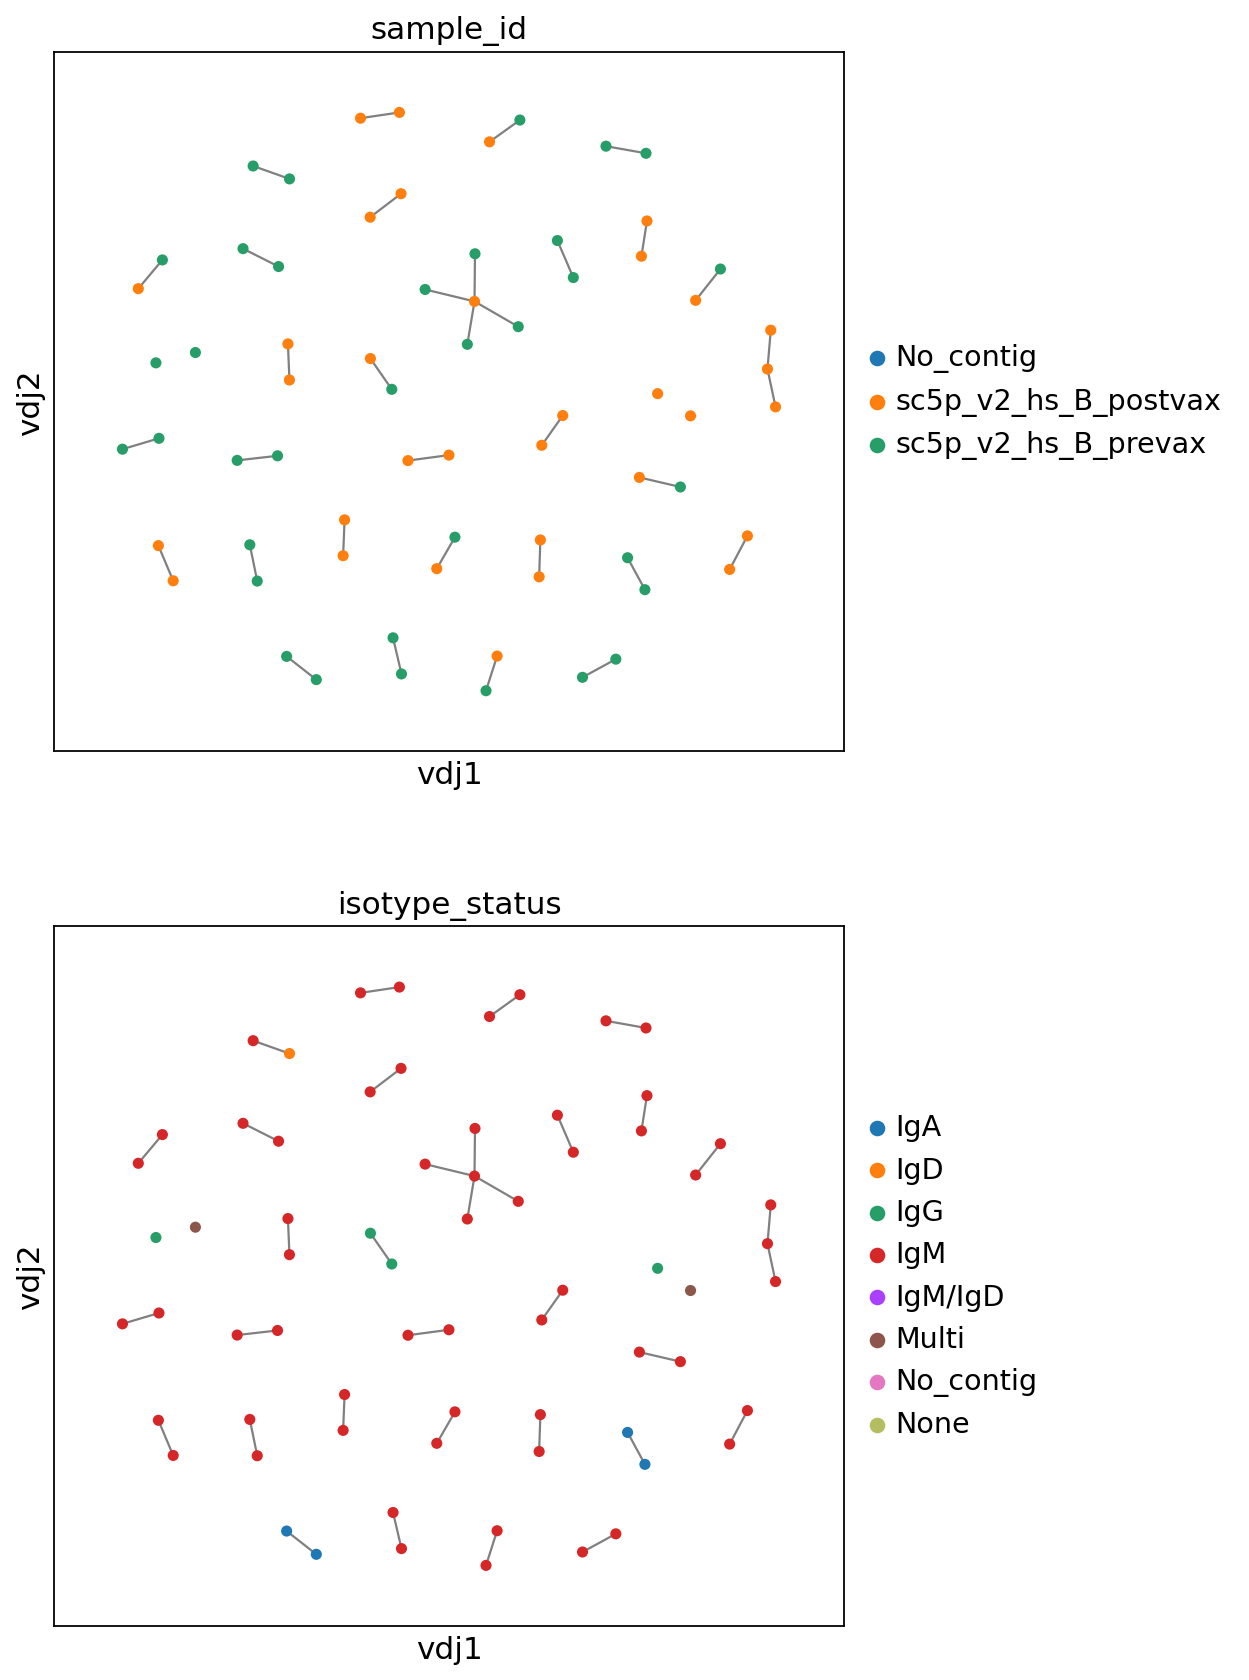

In [7]:
sc.set_figure_params(figsize = [6,6])
ddl.pl.clone_network(adata,
                     color = ['sample_id', 'isotype_status'],
                     edges_width = 1,
                     size = 100,
                     ncols = 1
                     )

Remember, this is only 5000 contigs because we trimmed this earlier. Try it again without trimming!

For more in-depth tutorial and examples of the workflow, please visit `dandelion`'s [documentation](https://sc-dandelion.readthedocs.io/) and [github repository](https://github.com/zktuong/dandelion).